In [26]:
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [27]:
cresci=r"c:/Users/bhavi/OneDrive/Desktop/acklen/Fake account/cresci-2017"

In [28]:

BASE_DIR = cresci

def safe_read_csv(path):
    try:
        return pd.read_csv(path, encoding="utf-8")
    except:
        return pd.read_csv(path, encoding="latin1")

def infer_label(path):
    return 0 if "genuine_accounts" in path else 1

users, tweets = [], []

for root, _, files in os.walk(BASE_DIR):
    for f in files:
        p = os.path.join(root, f)
        if f == "users.csv":
            df = safe_read_csv(p)
            df["label"] = infer_label(root)
            users.append(df)
        elif f == "tweets_filtered.csv":
            df = safe_read_csv(p)
            df["label"] = infer_label(root)
            tweets.append(df)

users_df = pd.concat(users, ignore_index=True)
tweets_df = pd.concat(tweets, ignore_index=True)


In [29]:
meta_features = [
    "statuses_count",
    "friends_count",
    "favourites_count",
    "listed_count",
    "utc_offset",
    "log_followers_count",
    "ff_ratio",
    "statuses_per_day",
    "listed_count",
]


In [30]:
users_df["ff_ratio"] = users_df["followers_count"] / (users_df["friends_count"] + 1)

users_df["created_at_parsed"] = pd.to_datetime(
    users_df["created_at"],
    errors="coerce",
    utc=True
)

now_utc = pd.Timestamp.now(tz="UTC")

users_df["account_age_days"] = (
    now_utc - users_df["created_at_parsed"]
).dt.days

users_df["statuses_per_day"] = (
    users_df["statuses_count"] / (users_df["account_age_days"] + 1)
)

users_df["has_profile_pic"] = users_df["profile_image_url"].notnull().astype(int)
now_utc = pd.Timestamp.now(tz="UTC")

users_df["account_age_days"] = (
    now_utc - users_df["created_at_parsed"]
).dt.days


C:\Users\bhavi\AppData\Local\Temp\ipykernel_21064\899727982.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  users_df["created_at_parsed"] = pd.to_datetime(


In [31]:
for col in ["followers_count", "friends_count", "statuses_count"]:
    users_df[f"log_{col}"] = np.log1p(users_df[col])


In [32]:
X_meta = users_df[meta_features]
y = users_df["label"]

In [33]:
X_meta_train,X_meta_test,y_train,y_test=train_test_split(X_meta,y,test_size=0.2, random_state=42,stratify=y  )

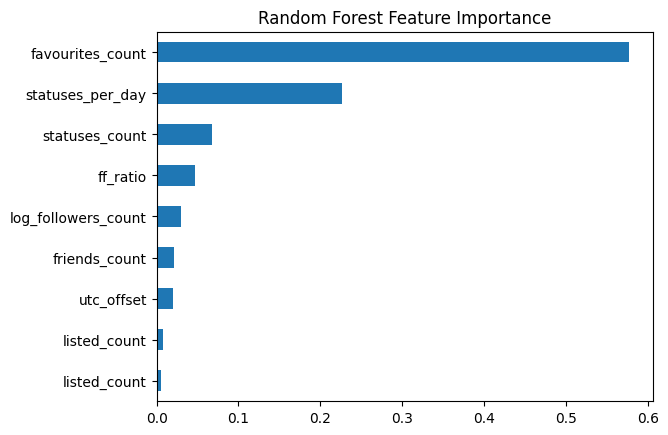

In [44]:

rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=8,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_meta_train, y_train)

importances = pd.Series(rf.feature_importances_, index=meta_features)
importances.sort_values().plot(kind="barh")
plt.title("Random Forest Feature Importance")
plt.show()


In [45]:
y_pred = rf.predict(X_meta_test)
y_prob = rf.predict_proba(X_meta_test)


In [46]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9850382741823243


In [47]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       695
           1       0.99      0.99      0.99      2179

    accuracy                           0.99      2874
   macro avg       0.98      0.98      0.98      2874
weighted avg       0.99      0.99      0.99      2874



In [48]:
import joblib

joblib.dump(rf, "random_forest_model.pkl")


['random_forest_model.pkl']